In [1]:
!pip3 install pandas
!pip3 install scikit-learn
!pip3 install matplotlib
!pip3 install numpy
!pip3 install imblearn

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score, recall_score
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn import tree
import numpy as np
import matplotlib.pyplot as plt

# Colunas do dataset ordenadas pela relevância em relação à classificação
sorted_headers_relevance = [
    'polyuria', 'polydipsia', 'age', 'gender', 'sudden_weight_loss',
    'partial_paresis', 'polyphagia', 'irritability', 'alopecia', 'visual_blurring',
    'weakness', 'muscle_stiffness', 'genital_thrush', 'obesity', 'delayed_healing', 'itching'
]

# Carregar o CSV
data = pd.read_csv('../dataset-full.csv')

# Renomear os cabeçalhos para snake_case
data.columns = data.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')

# Tratar a coluna 'gender' manualmente (1 para Male, 2 para Female)
data['gender'] = data['gender'].map({'Male': 1, 'Female': 2})

# Converter outras colunas descritivas para numéricas com LabelEncoder
label_encoder = LabelEncoder()

# Utiliza o encoder para converter os dados de todas as colunas para numéricos
for column in sorted_headers_relevance + ['class']:
    data[column] = label_encoder.fit_transform(data[column])

# Separar o nosso alvo, resultado final, classificação de diabetes
y = data['class']

# captura colunas
X = data[sorted_headers_relevance]

# Separar os dados em treino e teste usando estratificação pela "class"
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7,random_state=42) 

Como o dataset possui classes desbalanceadas (mais de uma classe que a outra), o que é comum em problemas de saúde, a técnica SMOTE (Synthetic Minority Over-sampling Technique) é utilizada para separar os dados de treinamento.


# SMOTE
O SMOTE (Synthetic Minority Over-sampling Technique) é uma técnica de oversampling amplamente utilizada em problemas de aprendizado de máquina para lidar com datasets desbalanceados, onde uma classe (geralmente a classe minoritária) tem muito menos amostras do que outras.

## Como o SMOTE Funciona:
1. Identificação da Classe Minoritária: O SMOTE começa identificando a classe que está sub-representada no dataset. Por exemplo, em um problema de classificação binária com 1.000 exemplos da classe 0 (negativa) e apenas 100 exemplos da classe 1 (positiva), a classe 1 seria a classe minoritária.
2. Geração de Novas Amostras Sintéticas:
  - Em vez de simplesmente replicar exemplos da classe minoritária (como o oversampling simples faz), o SMOTE gera novos exemplos sintéticos.
  - Para cada ponto na classe minoritária, o SMOTE seleciona seus vizinhos mais próximos (k-vizinhos mais próximos, por padrão, k=5).
  - Ele então gera novos exemplos criando pontos intermediários entre o exemplo original e seus vizinhos. Isso significa que o SMOTE cria novas amostras "no meio do caminho" entre os exemplos reais da classe minoritária, em vez de simplesmente duplicá-los.
3. Novas Amostras para Equilibrar o Dataset: O processo é repetido até que o número de amostras da classe minoritária esteja mais equilibrado com o da classe majoritária.

## Etapas Visuais do SMOTE:
1. Dataset Original (Desbalanceado):
- Classe majoritária (muitos exemplos).
- Classe minoritária (poucos exemplos).
2. Aplicação do SMOTE:
- Novos pontos sintéticos são criados para a classe minoritária com base nos vizinhos mais próximos.
3. Dataset Final (Balanceado):
- Mais exemplos na classe minoritária, agora próximo ao número de exemplos da classe majoritária.


## Alguns pontos sobre a escolha
- Ao balancear o dataset, o SMOTE ajuda o modelo a aprender melhor as características da classe minoritária, o que melhora a capacidade de prever casos dessa classe.
- Diferente de oversampling simples (onde os exemplos são apenas copiados), o SMOTE gera exemplos novos e únicos, evitando que o modelo aprenda padrões repetitivos.
- O SMOTE pode levar ao overfitting, especialmente se o número de vizinhos próximos ou o número de novas amostras geradas for muito alto. Isso ocorre porque os exemplos sintéticos criados podem não capturar bem a variação dos dados reais.
- Pode criar exemplos irreais ou ambíguos, especialmente se os dados da classe minoritária forem muito dispersos ou se houver muito ruído.



In [3]:
### 2. Balanceamento das Classes (SMOTE) ###
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

Aqui iniciamos a arvore de decisão em seu estado mais simples possível com valores padrões apenas para testar seu funcionamento

In [4]:
# Inicializar o modelo de Árvore de Decisão
gnb = DecisionTreeClassifier(random_state=42)

# Treinar o modelo com dados balanceados
gnb.fit(X_train_bal, y_train_bal)

# Fazer previsões no conjunto de teste
y_pred = gnb.predict(X_test)

### 5. Cross-validation (Validação Cruzada) ###
cross_val_recall = cross_val_score(gnb, X, y, cv=5, scoring='recall')
cross_val_accuracy = cross_val_score(gnb, X, y, cv=5, scoring='accuracy')

print(f"Mean Recall (Class 1) with Cross-Validation: {cross_val_recall.mean():.4f}")
print(f"Mean Accuracy with Cross-Validation: {cross_val_accuracy.mean():.4f}")


Mean Recall (Class 1) with Cross-Validation: 0.9719
Mean Accuracy with Cross-Validation: 0.9615


O GridSearchCV é uma ferramenta que ajuda a encontrar os melhores hiperparâmetros para um modelo de aprendizado de máquina.
Para isso, ele executa uma busca exaustiva sobre uma grade (grid) de parâmetros, testando todas as combinações possíveis desses parâmetros, para identificar a melhor configuração para o modelo.

Para o teste definimos alguns parâmetros relacionados permitidos para ajuste e definimos como medida de qualidade o recall

Como nossa base de dados é pequena foi possível utilizar o método de busca exaustiva, o que talvez não seria possível em dados maiores.

No total, ele testará 2 × 4 × 3 = 24 combinações diferentes de hiperparâmetros e escolherá aquela que produzir o melhor desempenho para o modelo.

Vantagens:
- Otimização automática: Facilita a escolha dos melhores parâmetros.
- Validação cruzada: Minimiza o risco de overfitting, já que o modelo é testado em várias divisões dos dados.
- Desempenho aprimorado: Ao encontrar os melhores hiperparâmetros, o modelo pode ter um desempenho muito superior ao modelo inicial com parâmetros padrão.


## Parâmetros
1. **criterion: ['gini', 'entropy']** (Verificar outros parametros)
Esse parâmetro define o critério de divisão para escolher os nós nas árvores de decisão, ou seja, ele decide como a árvore divide os dados em cada nível.

    - Gini: Refere-se ao índice de Gini, que mede a impureza de um nó. Ele tenta minimizar a probabilidade de classificar incorretamente um item aleatório no nó. O Gini é mais simples e frequentemente mais rápido de calcular.
    - Entropy: Refere-se à entropia usada na teoria da informação. Ela mede o grau de desordem ou incerteza. O critério de entropia tenta maximizar a "informação" que cada divisão gera, e tende a resultar em árvores um pouco mais balanceadas, embora possa ser ligeiramente mais lento do que o Gini.

    **Impacto no Modelo**: Gini tende a ser mais eficiente em termos de tempo, mas entropy pode ser mais eficaz em termos de divisão da árvore quando há muitos atributos complexos. Dependendo do critério escolhido, a árvore pode produzir diferentes conjuntos de regras e, em última análise, diferentes classificações.
2. **max_depth: [None, 10, 20, 30]**
Este parâmetro define a profundidade máxima da árvore de decisão. Ele controla até que ponto a árvore pode crescer antes de parar.
    
    - None: Significa que a árvore será expandida até que todas as folhas sejam puras (100% corretas) ou contenham menos amostras do que o valor de min_samples_split.
    
    - 10, 20, 30: Limita o número máximo de níveis da árvore. Por exemplo, com max_depth=10, a árvore pode ter no máximo 10 níveis de profundidade.
    
    **Impacto no Modelo**:  
    - Profundidade maior: Quanto mais profunda a árvore, mais complexa ela será, o que pode resultar em overfitting, ou seja, o modelo se ajusta tão bem aos dados de treino que tem um desempenho ruim em novos dados.
    - Profundidade menor: Limitar a profundidade impede que a árvore cresça demais, o que ajuda a evitar o overfitting, mas pode resultar em underfitting se a árvore for muito rasa e não capturar padrões suficientes dos dados.

3.**min_samples_split: [2, 5, 10]**
Este parâmetro controla o número mínimo de amostras necessárias para dividir um nó. Se o número de amostras em um nó for menor que esse valor, o nó não será dividido.
    
    - 2: A divisão ocorre assim que houver pelo menos 2 amostras em um nó.
    - 5 ou 10: Exige um número maior de amostras para que uma divisão ocorra, o que significa que a árvore não se ramificará tão rapidamente.        

**Impacto no Modelo**:
- min_samples_split menor (2): A árvore se torna mais complexa, com mais divisões, o que pode levar a overfitting.
- min_samples_split maior (5 ou 10): A árvore se torna mais simples, dividindo-se menos vezes, o que ajuda a prevenir overfitting, mas pode resultar em underfitting se não dividir o suficiente para capturar padrões importantes.





### Resumo do Impacto Geral:
- criterion: Muda a maneira como as divisões são escolhidas (Gini é mais simples, Entropy é mais focado em informação).
- max_depth: Controla o quão profunda a árvore pode ser (profundidades maiores podem levar ao overfitting, menores ao underfitting).
- min_samples_split: Controla o número mínimo de amostras necessárias para dividir um nó, onde valores maiores tendem a fazer com que a árvore seja mais simples.

In [5]:
### 6. Tuning de Hiperparâmetros (GridSearchCV) ###
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=5, scoring='recall')
grid_search.fit(X_train_bal, y_train_bal)

# Imprimir os melhores parâmetros
print(f"Melhores parâmetros encontrados: {grid_search.best_params_}")

# Utilizando o melhor modelo encontrado
best_model = grid_search.best_estimator_

print(f"Melhor modelo encontrado: {best_model}")

# Prever com o melhor modelo no conjunto de teste
y_pred_best = best_model.predict(X_test)

Melhores parâmetros encontrados: {'criterion': 'gini', 'max_depth': None, 'min_samples_split': 2}
Melhor modelo encontrado: DecisionTreeClassifier(random_state=42)


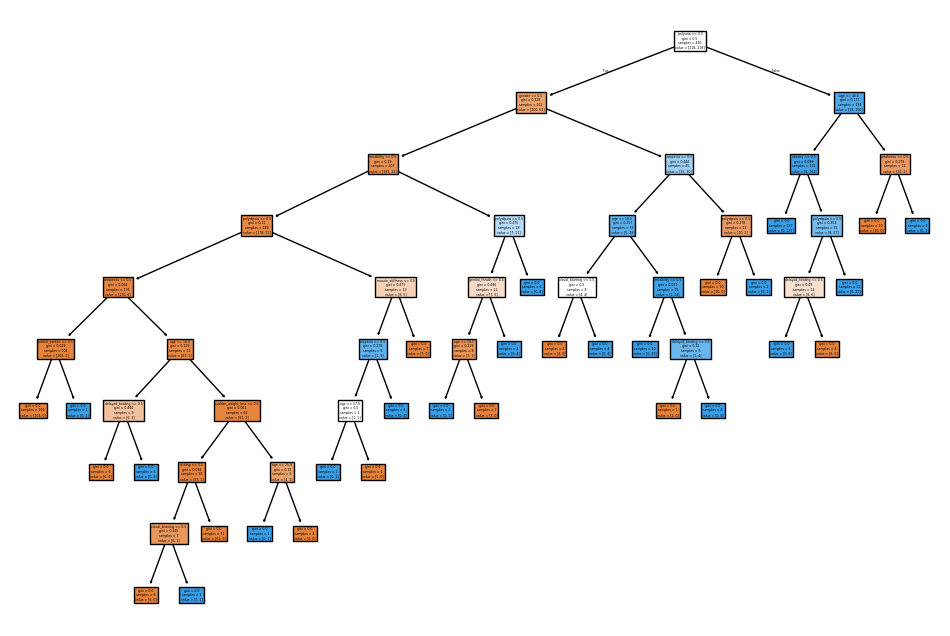

In [6]:
### 7. Visualização da Árvore de Decisão ###
plt.figure(figsize=(12, 8))
tree.plot_tree(best_model, filled=True, feature_names=sorted_headers_relevance)
plt.show()

In [7]:
# Avaliar o desempenho do modelo
recall_0 = recall_score(y_test, y_pred_best, pos_label=0)
recall_1 = recall_score(y_test, y_pred_best, pos_label=1)
accuracy = accuracy_score(y_test, y_pred_best)
f1 = f1_score(y_test, y_pred_best)

print(f"Recall Class 0: {recall_0:.4f}")
print(f"Recall Class 1: {recall_1:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")


Recall Class 0: 0.9630
Recall Class 1: 0.9608
Accuracy: 0.9615
F1 Score: 0.9703


Para melhor visualização vamos um gráfico com as medidas, mas ambas estão muito perto do valor de 100%

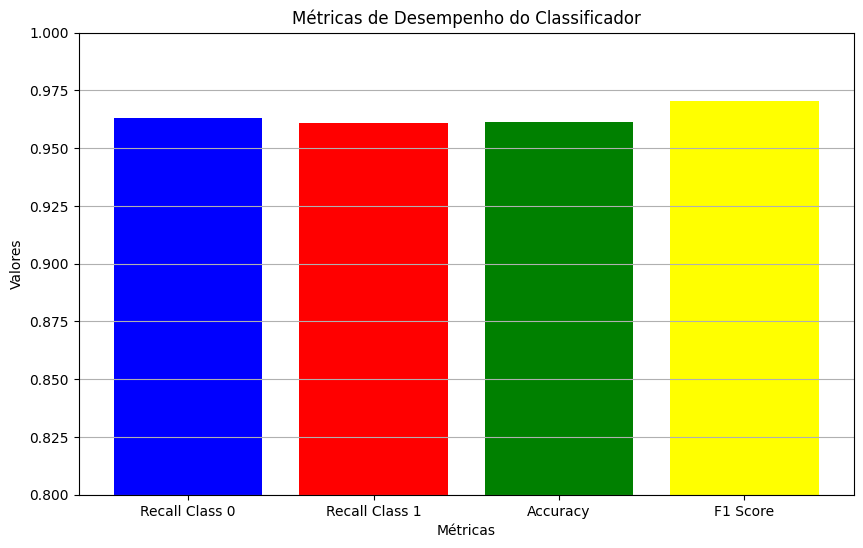

In [8]:
# Valores das métricas
metrics = {
    'Recall Class 0': recall_0,
    'Recall Class 1': recall_1,
    'Accuracy': accuracy,
    'F1 Score': f1
}

# Definir o título das barras e os valores
metric_names = list(metrics.keys())
metric_values = list(metrics.values())

# Criar o gráfico de barras
plt.figure(figsize=(10, 6))
plt.bar(metric_names, metric_values, color=['blue', 'red', 'green', 'yellow'])

# Configurações do gráfico
plt.title('Métricas de Desempenho do Classificador')
plt.xlabel('Métricas')
plt.ylabel('Valores')
plt.ylim(0.8, 1)  # Definir limite do eixo y já que as métricas são proporções e todas as medidas são acima de 80%
plt.grid(True, axis='y')

# Exibir o gráfico
plt.show()
